In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


C:\Users\gaurr\AppData\Local\Temp\ipykernel_26168\2658766297.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
from scipy import linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import cv2
import os
from collections import Counter
import pg_fitter_tools_new as fit
import sk_geo_tools as sk

In [5]:
# %matplotlib inline
import matplotlib
matplotlib.use('Qt5Agg')
plt.ion()

## Camera Settings

In [6]:
# model from 1 set of 100 image calibration in OpenCV
# fx, fy, cx, cy, k1, k2, k3, p1, p2 = 4.73809110e+03, 4.65803419e+03, 1.99925731e+03, 1.50215594e+03, -1.23429746e-01, -9.18241636e-01, 3.71519697e+00, -3.22955511e-03,  3.95755028e-03


# MATLAB model for old drone calibration
# fx, fy, cx, cy, k1, k2, k3, p1, p2, skew = 3.110658147486340e3, 3.112767335937938e3, 1.988185484316302e3, 1.510529274581101e3, -0.249726265925380, 0.169266475568445, 0, -9.742616359765806e-4, -8.761093588533360e-4, -6.8332

# MATLAB model for new drone calibration
# fx, fy, cx, cy, k1, k2, k3, p1, p2, skew = 2953.0, 2959.8, 1944, 1579.7, -0.2645, 0.1855, -0.0344, 2.0412e-4, 8.6272e-4, -8.5083

# OpenCV bootstrapping result
# fx, fy, cx, cy, k1, k2, k3, p1, p2, skew = 2768.853929, 2776.554415, 1988.764457, 1558.453228, -0.25680561, 0.15688786, -0.064053488, -0.00041878386, 0.000605649469, 0

# Model used by Nick in 24 PMT and ring reconstruction
fx, fy, cx, cy, k1, k2, k3, p1, p2, skew = 2.760529621789217e3, 2.767014510543478e3, 1.914303537872458e3, 1.596386868474348e3, -0.2398, 0.1145, 0, 0, 0, 0

focal_length = np.array([fx, fy])
principle_point = np.array([cx, cy])
radial_distortion = np.array([k1, k2, k3])
tangential_distortion = np.array([p1, p2])
# skew = 0

## Load data from files
* Load all PMT locations
* Load image feature locations

In [7]:
all_pmt_locations = fit.read_3d_feature_locations("parameters/SK_all_PMT_locations.txt") ## cylindrical seed geometry
# all_pmt_locations = fit.read_3d_feature_locations("parameters/dat/pmt_sm_position_polygon.txt") ## polygonal seed geometry
offset = np.array([0, 250])

In [5]:
# plot the PMT locations
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
pmt_array = np.stack(list(all_pmt_locations.values()))
ax.scatter(pmt_array[:,0], pmt_array[:,1], pmt_array[:,2], marker='.', label="PMT (seed position)")
plt.legend(loc=0)
plt.xlabel("x [cm]", fontsize=12)
plt.ylabel("y [cm]", fontsize=12)
ax.set_zlabel("z [cm]", fontsize=12)
ax.set_title("Seed Positions for the Super-K Detector")
fig.tight_layout()



In [8]:
path = 'source/LI_points/' # GUI feature detection and labeling
# path = 'BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/' # 24 PMT manual feature detection and labeling

image_feature_locations = {}

# pass all of the text files in path to read_image_feature_locations
for file in os.listdir(path):
    if file.endswith(".txt"):
        image_feature_locations.update(fit.read_image_feature_locations(path+file, offset=offset))


In [17]:
# swap out -25 and -00 for features in images where both exist
for im in image_feature_locations.values():
    for feat, loc in im.items():
        if feat[-2:] == "00" and feat[:-2]+"25" in im:
            tmp = loc
            im[feat] = im[feat[:-2]+"25"]
            im[feat[:-2]+"25"] = tmp

In [9]:
# For comparisons with 24 PMT manual labeling study

# look through image_feature_locations and keep only the keys with the following values '1045', '1046', '1047', '1048', '1086', '1087', '1124', '1125', '1126', '1127', '1236', '1237', '1238', '1239', '1240'
image_feature_locations = {k: v for k, v in image_feature_locations.items() if k in ['1045', '1046', '1047', '1048', '1086', '1087', '1236', '1237', '1238', '1239', '1240']}

# go through each image in image_feature_locations. If the feature does not begin with '00810', '00809', '00808', '00807', '00759', '00758', '00757', '00708', '00707', '00706', '00657', '00656', '00655', '00606', '00605', '00604', '00555', '00554', '00553', '00504', '00503', '00502', '00453', '00452', or '00451', remove it from the image
for im in image_feature_locations.values():
    for feat in list(im):
        if feat[:5] not in ['00810', '00809', '00808', '00759', '00758', '00757', '00708', '00707', '00706', '00657', '00656', '00655', '00606', '00605', '00604', '00555', '00554', '00553', '00504', '00503', '00502', '00453', '00452', '00451']:
            del im[feat]


In [10]:
# choose features that appear in 2+
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
common_features = [f for f in feature_counts if feature_counts[f] > 1]
pmt_locations = {k: p for k, p in all_pmt_locations.items() if k in common_features}

print("The number of features that appear in 2+ images is", len(common_features))

The number of features that appear in 2+ images is 599


In [11]:

# generate bolt locations from PMT locations
bolt_locations = sk.get_bolt_locations_barrel(pmt_locations)

In [12]:
common_bolt_locations = {k: b for k, b in bolt_locations.items() if k in common_features}
common_feature_locations = {**pmt_locations, **bolt_locations}
common_image_pmt_locations = {
    k: {j: f for j, f in i.items() if j in common_features and j in pmt_locations}
    for k, i in image_feature_locations.items()}

common_image_feature_locations = {
    k: {j: f for j, f in i.items() if j in common_features and j in common_feature_locations}
    for k, i in image_feature_locations.items()}

common_image_bolt_locations = {
    k: {j: f for j, f in i.items() if j in common_features and j in bolt_locations}
    for k, i in image_feature_locations.items()}

nimages = len(common_image_feature_locations) # number of images with common features
nfeatures = len(common_feature_locations) # number of features that appear in at least 2 images

print("The number of images and common features is", nimages, nfeatures)

The number of images and common features is 11 600


## Plot seed positions for PMTs and bolts

In [13]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
bolt_array = np.stack(list(bolt_locations.values()))
pmt_array = np.stack(list(pmt_locations.values()))
ax.scatter(bolt_array[:,0], bolt_array[:,1], bolt_array[:,2], marker='.', label="Bolt (seed position)")
ax.scatter(pmt_array[:,0], pmt_array[:,1], pmt_array[:,2], marker='^', label="PMT (seed position)")
# for i, f in enumerate(pmt_locations.keys()):
#     ax.text(pmt_array[i,0], pmt_array[i,1], pmt_array[i,2], f[:5], size=8, zorder=4, color='k') 
plt.legend(loc=0)
fig.tight_layout()

ax.set_xlabel("x [cm]", fontsize=12)
ax.set_ylabel("y [cm]", fontsize=12)
ax.set_zlabel("z [cm]", fontsize=12)
ax.set_title("Seed Positions")

# rotate the plot
ax.view_init(0, 210)
plt.show()

In [14]:
# top view of seed positions

fig, ax = plt.subplots(figsize=(9,9))
bolt_array = np.stack(list(bolt_locations.values()))
pmt_array = np.stack(list(pmt_locations.values()))
ax.scatter(bolt_array[:,0], bolt_array[:,1], marker='.', label="Bolt (seed position)")
ax.scatter(pmt_array[:,0], pmt_array[:,1], marker='^', label="PMT (seed position)")
ax.set_ylim((500,1050))
ax.set_xlim((1200,1800))
plt.legend(loc=0)
ax.set_xlabel("x [cm]", fontsize=12)
ax.set_ylabel("y [cm]", fontsize=12)
ax.set_title("Seed Positions (Top View)")
fig.tight_layout()

## Create fitter objects

In [ ]:
fitter_pmts = fit.PhotogrammetryFitter(common_image_pmt_locations, pmt_locations,
                                       focal_length, principle_point, skew, radial_distortion, tangential_distortion)
fitter_bolts = fit.PhotogrammetryFitter(common_image_bolt_locations, common_bolt_locations,
                                       focal_length, principle_point, skew, radial_distortion, tangential_distortion)
fitter_all = fit.PhotogrammetryFitter(common_image_feature_locations, common_feature_locations,
                                       focal_length, principle_point, skew, radial_distortion, tangential_distortion)


In [19]:
print(common_image_feature_locations)
print(common_feature_locations)

{'1045': {'00555-00': array([3503., 2371.]), '00555-01': array([3529., 2269.]), '00555-02': array([3562., 2271.]), '00555-03': array([3593., 2282.]), '00555-04': array([3623., 2306.]), '00555-05': array([3646., 2326.]), '00555-06': array([3656., 2364.]), '00555-07': array([3661., 2399.]), '00555-08': array([3655., 2434.]), '00555-09': array([3644., 2466.]), '00555-10': array([3624., 2491.]), '00555-11': array([3595., 2512.]), '00555-12': array([3556., 2523.]), '00555-13': array([3521., 2526.]), '00555-14': array([3483., 2525.]), '00555-15': array([3448., 2511.]), '00555-16': array([3423., 2487.]), '00555-17': array([3407., 2461.]), '00555-18': array([3395., 2430.]), '00555-19': array([3389., 2394.]), '00555-20': array([3392., 2361.]), '00555-21': array([3406., 2330.]), '00555-22': array([3430., 2307.]), '00555-23': array([3459., 2289.]), '00555-24': array([3490., 2275.]), '00605-00': array([3192., 2656.]), '00605-01': array([3204., 2555.]), '00605-02': array([3239., 2564.]), '00605-03'


## Estimate camera poses assuming seed feature positions

In [16]:
camera_rotations, camera_translations, reprojected_points = fitter_all.estimate_camera_poses(flags=cv2.SOLVEPNP_EPNP)

image 0 reprojection errors:    average:3.768083866228121   max: 11.300533224592547
image 1 reprojection errors:    average:4.142303847409485   max: 13.52285678465825
image 2 reprojection errors:    average:4.525254062151684   max: 17.169179300970594
image 3 reprojection errors:    average:4.41805492493177   max: 15.077824424490522
image 4 reprojection errors:    average:3.855589484737664   max: 13.766330225630385
image 5 reprojection errors:    average:3.2904611354361246   max: 15.262499172385052
image 6 reprojection errors:    average:3.681321119480176   max: 12.678482500557703
image 7 reprojection errors:    average:3.5914101515161896   max: 11.96693003118343
image 8 reprojection errors:    average:3.237905138061363   max: 17.21129600884492
image 9 reprojection errors:    average:3.2147152796301413   max: 13.561453693617645
image 10 reprojection errors:    average:3.1575561689297893   max: 11.802213447761837


### Output a few of the features with largest errors for manual checking

In [44]:
max = 0
im = ""
feat = ""
im2 = ""
feat2 = ""
for i, ii in reprojected_points.items():
    for f, ff in ii.items():
        if linalg.norm(ff-image_feature_locations[i][f]) > max:
            im3 = im2
            feat3 = feat2
            im2 = im
            feat2 = feat
            im = i
            feat = f
print(im, feat, fitter_all.image_index[im])
print(im2, feat2, fitter_all.image_index[im2])
print(im3, feat3, fitter_all.image_index[im3])

image 0 reprojection errors:    average:9.021409889038901   max: 20.83656963453953
image 1 reprojection errors:    average:8.892650948172806   max: 22.918614549666174
image 2 reprojection errors:    average:7.44331143279603   max: 23.869338582349783
image 3 reprojection errors:    average:7.906758372936613   max: 21.047034896178
image 4 reprojection errors:    average:7.13704479081576   max: 22.35358012189362
image 5 reprojection errors:    average:9.78265359567798   max: 47.00259766496068
image 6 reprojection errors:    average:12.294239656319656   max: 38.59949356759608
image 7 reprojection errors:    average:6.048613014088925   max: 30.66920673556508
image 8 reprojection errors:    average:6.628105874490164   max: 17.030180817655804
image 9 reprojection errors:    average:5.752486271196467   max: 20.05499817394872
image 10 reprojection errors:    average:10.175247813697482   max: 26.345933449201322
image 11 reprojection errors:    average:6.906638333070471   max: 35.89750301214494
i

### Plot overlay of reprojected and observed feature locations for manual checking

In [17]:
test_image = 0
fig, ax = plt.subplots(figsize=(12,9))
coords = np.stack(list(common_image_feature_locations[fitter_pmts.index_image[test_image]].values()))
repro_coords = np.stack(list(reprojected_points[fitter_pmts.index_image[test_image]].values()))
ax.scatter(coords[:,0], 3000-coords[:,1], marker='.', label='detected')
ax.scatter(repro_coords[:,0], 3000-repro_coords[:,1], marker='.', label='reprojected')

for t, f in common_image_feature_locations[fitter_pmts.index_image[test_image]].items(): #
    # print only PMT labels, those that end with "00"
    if t[-2:] == "00":
        ax.text(f[0], 3000-f[1], t, size=6, zorder=4, color='k')

for t, f in reprojected_points[fitter_pmts.index_image[test_image]].items():
    if t[-2:] == "00":
        ax.text(f[0], 3000-f[1], t, size=6, zorder=4, color='yellow')

ax.set_title("Image {}".format(fitter_pmts.index_image[test_image]))
ax.set_ylim(0, 3000)
ax.set_xlim(0, 4000)
plt.legend(loc=0)
fig.tight_layout()

### Plot camera position estimates in 3D

In [65]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)

In [ ]:
fig = plt.figure(figsize=(12,9))
pmt_array = np.stack(list(pmt_locations.values()))
feat_array = np.stack(list(common_feature_locations.values()))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feat_array[:,0], feat_array[:,1], feat_array[:,2], marker='.', label="seed positions", zorder=2)
for i, f in enumerate(pmt_locations.keys()):
    ax.text(pmt_array[i,0], pmt_array[i,1], pmt_array[i,2], f[:5], size=4, zorder=4, color='k') 
ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera estimate", zorder=1)
plt.legend(loc=0)
fig.tight_layout()
# rotate the plot to see the bolt ring
ax.view_init(30, -100)

In [18]:
## Saving necessary results to text files

# change the shape of camera_orientations such that it is each 3x3 matrix in the array is a row
camera_orientations = camera_orientations.reshape((camera_orientations.shape[0], 9))

# change shape of camera_positions to be each row is a camera position
camera_positions = camera_positions.reshape((camera_positions.shape[0], 3))

# save camera positions and camera orientations to a text file called "reproduce_camera_poses.txt" and put it in the 'results/24_PMT_Study/' folder. Add a column in the beginning with the image name
np.savetxt('results/24_PMT_Study/MATLAB/newFD_camera_poses_matlab_polygon.txt', np.hstack((np.array([fitter_all.index_image[i] for i in range(len(fitter_all.index_image))]).reshape((len(fitter_all.index_image), 1)), camera_positions, camera_orientations)), fmt='%s', delimiter='\t')

# save the reprojected points to a text file called "reproduce_reprojected_points.txt" and put it in the 'results/24_PMT_Study/' folder. Add a column in the beginning with the image name
np.savetxt('results/24_PMT_Study/MATLAB/newFD_reprojected_points_matlab_polygon.txt', np.hstack((np.array([fitter_all.index_image[i] for i in range(len(fitter_all.index_image))]).reshape((len(fitter_all.index_image), 1)), np.array(list(reprojected_points.values())).reshape((len(fitter_all.index_image), -1)))), fmt='%s', delimiter='\t')


## Perform bundle asjustment starting from seed geometry and estimated camera poses

In [72]:
for i in range(4):
    camera_rotations, camera_translations, reco_locations = fitter_all.bundle_adjustment(camera_rotations, camera_translations, use_sparsity=True, fit_cam=False)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.4962e+04                                    1.61e+06    
       1              2         1.5090e+04      1.99e+04       1.89e+01       3.03e+04    
       2              3         1.3879e+04      1.21e+03       1.05e+01       4.74e+04    
       3              4         1.3284e+04      5.95e+02       2.83e+00       1.18e+04    
       4              5         1.3168e+04      1.16e+02       1.10e+00       6.37e+03    
       5              6         1.3099e+04      6.91e+01       6.88e-01       6.21e+03    
       6              7         1.3067e+04      3.16e+01       3.29e-01       4.68e+03    
       7              8         1.3049e+04      1.75e+01       1.78e-01       4.14e+03    
       8              9         1.3035e+04      1.48e+01       1.87e-01       5.16e+03    
       9             10         1.3020e+04      1.42e+01       1.53e-01       5.67e+03    

## Extract fit errors and make relevant plots

In [48]:
print(fitted_cam_matrix)
print(fitted_distortion)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2058e+07                                    3.01e+08    
       1              2         3.7926e+06      8.27e+06       2.10e+02       1.83e+07    
       2              3         3.2393e+06      5.53e+05       4.01e+01       2.70e+06    
       3              4         2.9588e+06      2.80e+05       2.87e+01       2.03e+06    
       4              5         2.7464e+06      2.12e+05       2.22e+01       1.57e+06    
       5              6         2.6245e+06      1.22e+05       1.30e+01       1.39e+06    
       6              7         2.5339e+06      9.06e+04       1.16e+01       1.24e+06    
       7              8         2.4525e+06      8.14e+04       1.01e+01       1.21e+06    
       8              9         2.3769e+06      7.56e+04       1.04e+01       1.09e+06    
       9             10         2.3064e+06      7.05e+04       9.29e+00       1.08e+06    

In [22]:
# offset = 4+fitted_distortion.shape[0]

# convert the entries from opt.jac to dtype float
# opt.jac = opt.jac.astype(np.uint8)

J=opt.jac[:,fitter_all.nimages*6:].toarray() # Jacobian matrix for the feature locations
U, s, Vh = linalg.svd(J, full_matrices=False) # singular value decomposition. U and Vh are unitary matrices, s contains J's singular values
tol = np.finfo(float).eps*s[0]*max(J.shape) # tolerance for zero singular values
w = s > tol # indices of nonzero singular values
cov = (Vh[w].T/s[w]**2) @ Vh[w]  # robust covariance matrix
perr = np.sqrt(np.diag(cov))     # 1sigma uncertainty on fitted parameters
feature_location_errors = perr.reshape((-1, 3))

opt.fun.size # number of residuals
opt.x.size # number of parameters
opt.nfev # number of function evaluations
opt.njev # number of jacobian evaluations
perr.size # number of fitted parameters

chi2dof = np.sum(opt.fun**2)/(opt.fun.size - perr.size) # chi2 per degree of freedom
cov_scaled = cov*chi2dof # scaled covariance matrix
perr = np.sqrt(np.diag(cov_scaled))    # 1sigma uncertainty on fitted parameters
feature_location_errors = perr.reshape((-1, 3)) # reshape to match feature locations

Text(0.5, 1.0, 'Fitter Error on Feature Positions')

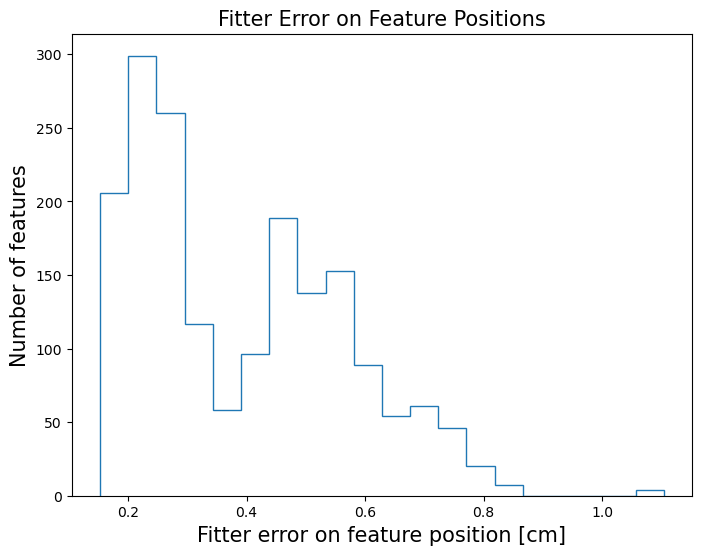

In [23]:
# plot histogram of errors on feature locations
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(feature_location_errors.flatten(), bins=20, histtype="step")
ax.set_xlabel("Fitter error on feature position [cm]", fontsize=15)
ax.set_ylabel("Number of features", fontsize=15)
ax.set_title("Fitter Error on Feature Positions", fontsize=15)

In [24]:
# separating out the errors into x, y, z components
x_variance = np.diag(cov_scaled)[0::3]
y_variance = np.diag(cov_scaled)[1::3]
z_variance = np.diag(cov_scaled)[2::3]
variance_3d = x_variance + y_variance + z_variance
xy_covariance = cov_scaled[range(0,cov_scaled.shape[0],3),range(1,cov_scaled.shape[1],3)]
xz_covariance = cov_scaled[range(0,cov_scaled.shape[0],3),range(2,cov_scaled.shape[1],3)]
yz_covariance = cov_scaled[range(1,cov_scaled.shape[0],3),range(2,cov_scaled.shape[1],3)]
radial_positions = linalg.norm(fitter_all.reco_locations[:,:2], axis=1)
x_positions = fitter_all.reco_locations[:,0]
y_positions = fitter_all.reco_locations[:,1]
z_positions = fitter_all.reco_locations[:,2]
radial_variance = ((x_positions**2)*x_variance+(y_positions**2)*y_variance+2*x_positions*y_positions*xy_covariance)/radial_positions**2
tangential_variance = variance_3d-radial_variance

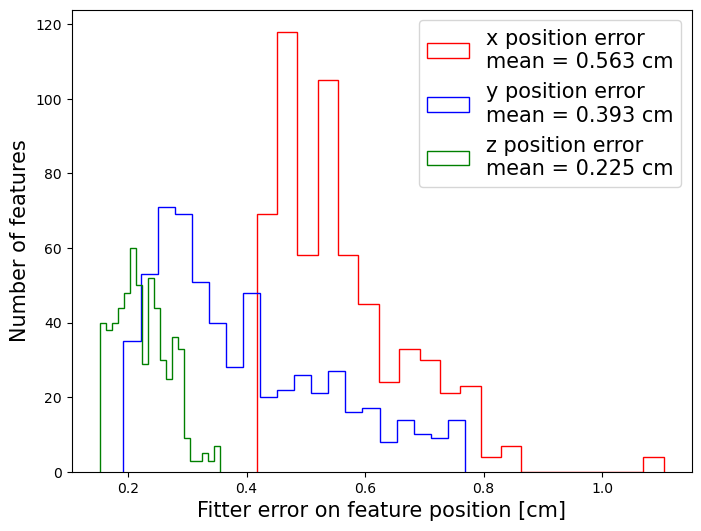

In [25]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(np.sqrt(x_variance), bins=20, histtype="step", color="r", label=f"x position error\nmean = {np.mean(np.sqrt(x_variance)):.3} cm")
ax.hist(np.sqrt(y_variance), bins=20, histtype="step", color="b", label=f"y position error\nmean = {np.mean(np.sqrt(y_variance)):.3} cm")
ax.hist(np.sqrt(z_variance), bins=20, histtype="step", color="g", label=f"z position error\nmean = {np.mean(np.sqrt(z_variance)):.3} cm")
ax.set_xlabel("Fitter error on feature position [cm]", fontsize=15)
ax.set_ylabel("Number of features", fontsize=15)
plt.legend(loc="upper right", prop={'size': 15})

Text(0.5, 1.0, 'Fitter Error on 3D Feature Positions')

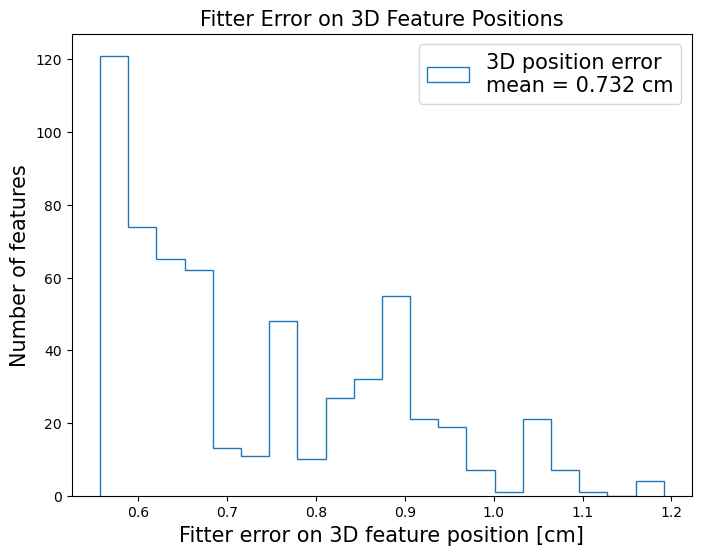

In [26]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(np.sqrt(variance_3d), bins=20, histtype="step", label=f"3D position error\nmean = {np.mean(np.sqrt(variance_3d)):.3} cm")
ax.set_xlabel("Fitter error on 3D feature position [cm]", fontsize=15)
ax.set_ylabel("Number of features", fontsize=15)
plt.legend(loc="upper right", prop={'size': 15})
ax.set_title("Fitter Error on 3D Feature Positions", fontsize=15)

Text(0.5, 1.0, 'Fitter Error on Radial and Tangential Feature Positions')

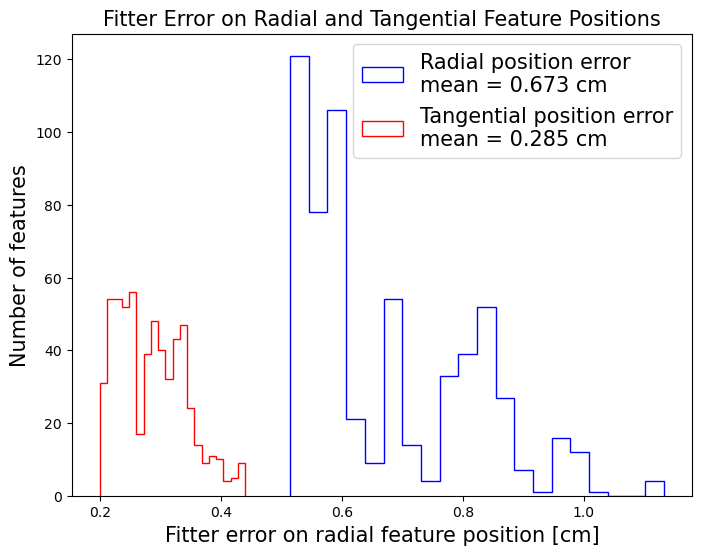

In [27]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(np.sqrt(radial_variance), bins=20, histtype="step", color="b", label=f"Radial position error\nmean = {np.mean(np.sqrt(radial_variance)):.3} cm")
ax.hist(np.sqrt(tangential_variance), bins=20, histtype="step", color="r", label=f"Tangential position error\nmean = {np.mean(np.sqrt(tangential_variance)):.3} cm")
ax.set_xlabel("Fitter error on radial feature position [cm]", fontsize=15)
ax.set_ylabel("Number of features", fontsize=15)
plt.legend(loc="upper right", prop={'size': 15})
ax.set_title("Fitter Error on Radial and Tangential Feature Positions", fontsize=15)

In [28]:
## Save all the fitter errors

# save the fitter errors to a text file called "newFD_fitter_errors.txt" and put it in the 'results/24_PMT_Study/' folder
np.savetxt('results/24_PMT_Study/MATLAB/newFD_fitter_errors_matlab_polygon.txt', np.hstack((np.array([fitter_all.index_feature[i] for i in range(len(fitter_all.index_feature))]).reshape((len(fitter_all.index_feature), 1)), np.sqrt(variance_3d).reshape((len(fitter_all.index_feature), 1)))), fmt='%s', delimiter='\t')

# save the x, y, z, fitter position errors to a text file called "newFD_xyz_errors.txt" and put it in the 'results/24_PMT_Study/' folder
np.savetxt('results/24_PMT_Study/MATLAB/newFD_xyz_errors_matab_polygon.txt', np.hstack((np.array([fitter_all.index_feature[i] for i in range(len(fitter_all.index_feature))]).reshape((len(fitter_all.index_feature), 1)), np.sqrt(x_variance).reshape((len(fitter_all.index_feature), 1)), np.sqrt(y_variance).reshape((len(fitter_all.index_feature), 1)), np.sqrt(z_variance).reshape((len(fitter_all.index_feature), 1)))), fmt='%s', delimiter='\t')

# save the radial and tangential fitter position errors to a text file called "newFD_radial_tangential_errors.txt" and put it in the 'results/24_PMT_Study/' folder
np.savetxt('results/24_PMT_Study/MATLAB/newFD_radtan_errors_matlab_polygon.txt', np.hstack((np.array([fitter_all.index_feature[i] for i in range(len(fitter_all.index_feature))]).reshape((len(fitter_all.index_feature), 1)), np.sqrt(radial_variance).reshape((len(fitter_all.index_feature), 1)), np.sqrt(tangential_variance).reshape((len(fitter_all.index_feature), 1)))), fmt='%s', delimiter='\t')


## Kabsch algorithm to match reconstructed coordinate system to seed co-ordinate system

In [73]:
errors, reco_transformed, scale, R, translation, location_mean = fit.kabsch_errors(
    common_feature_locations, reco_locations)
print("mean reconstruction error:", linalg.norm(errors, axis=1).mean())
print("max reconstruction error:", linalg.norm(errors, axis=1).max())

mean reconstruction error: 1.1247153690788192
max reconstruction error: 4.021737058356666


In [74]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
camera_orientations = np.matmul(R, camera_orientations)
camera_positions = camera_positions - translation
camera_positions = scale*R.dot(camera_positions.transpose()).transpose() + location_mean

## Save results to file

In [185]:
outputdir = "results/"
fileroot = "SK_demo2"

# For ROOT analysis
fitter_all.save_result(outputdir+fileroot+"_features.txt", outputdir+fileroot+"_cameras.txt")

# For Python analysis
import pickle
with open(outputdir+fileroot+'.pkl', 'wb') as output:
    pickle.dump(fitter_all, output, pickle.HIGHEST_PROTOCOL)

## Plots of reconstructed geometry

In [75]:
true_array = np.stack(list(common_feature_locations.values()))


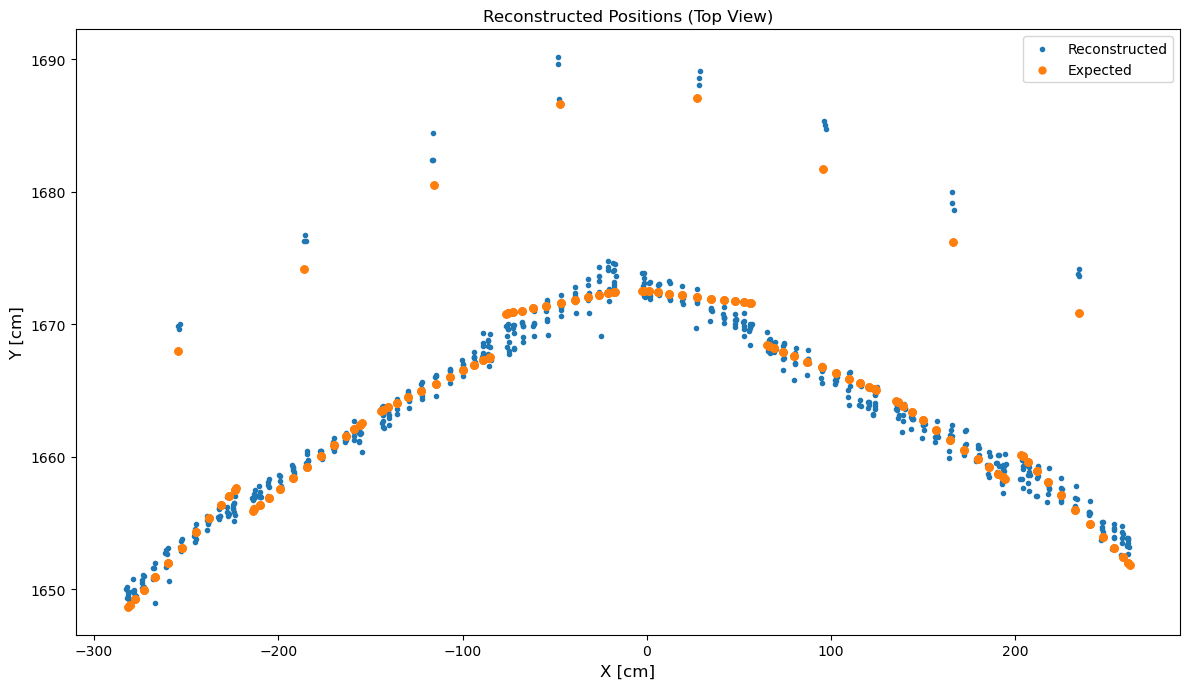

In [76]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
rot_theta = (90-27.261)*np.pi/180
ax.scatter(reco_transformed[:,0]*np.cos(rot_theta)-reco_transformed[:,1]*np.sin(rot_theta), reco_transformed[:,0]*np.sin(rot_theta)+reco_transformed[:,1]*np.cos(rot_theta), marker='.', label="Reconstructed")
ax.scatter(true_array[:,0]*np.cos(rot_theta)-true_array[:,1]*np.sin(rot_theta), true_array[:,0]*np.sin(rot_theta)+true_array[:,1]*np.cos(rot_theta), marker='.', label="Expected", s=100)
#ax.set_ylim((500,1050))
#ax.set_xlim((1320,1600))
# circle = plt.Circle((0, 0), 1690-15, color='black', fill=False)
# ax.add_artist(circle)
# for i, f in enumerate(pmt_locations.keys()):
#    ax.text(reco_transformed[i,0], reco_transformed[i,1], f, size=4, zorder=1, color='k') 
#ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera")
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.set_xlabel("X [cm]", fontsize=12)
ax.set_ylabel("Y [cm]", fontsize=12)
ax.set_title("Reconstructed Positions (Top View)")
plt.legend(loc=0)
fig.tight_layout()

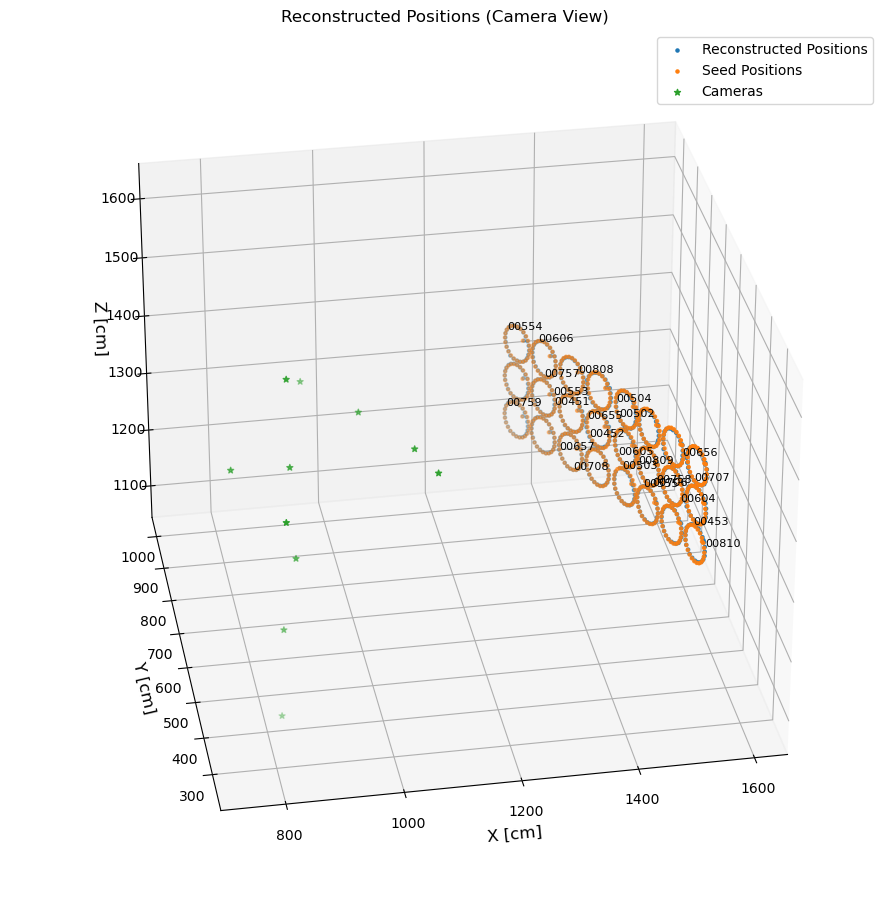

In [77]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reco_transformed[:,0], reco_transformed[:,1], reco_transformed[:,2], marker='.', label="Reconstructed Positions", zorder=3)
ax.scatter(true_array[:,0], true_array[:,1], true_array[:,2], marker='.', label="Seed Positions", zorder=2)

for i, f in enumerate(pmt_locations.keys()):
    ax.text(reco_transformed[i,0], reco_transformed[i,1], reco_transformed[i,2], f[:5], size=8, zorder=4, color='k')

ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="Cameras", zorder=1) # plotting reconstructed camera poses
ax.set_xlabel("X [cm]", fontsize=12)
ax.set_ylabel("Y [cm]", fontsize=12)
ax.set_zlabel("Z [cm]", fontsize=12)
plt.legend(loc=0)
fig.tight_layout()
ax.set_title("Reconstructed Positions (Camera View)")
# rotate the plot to see the bolt ring
ax.view_init(30, -100)

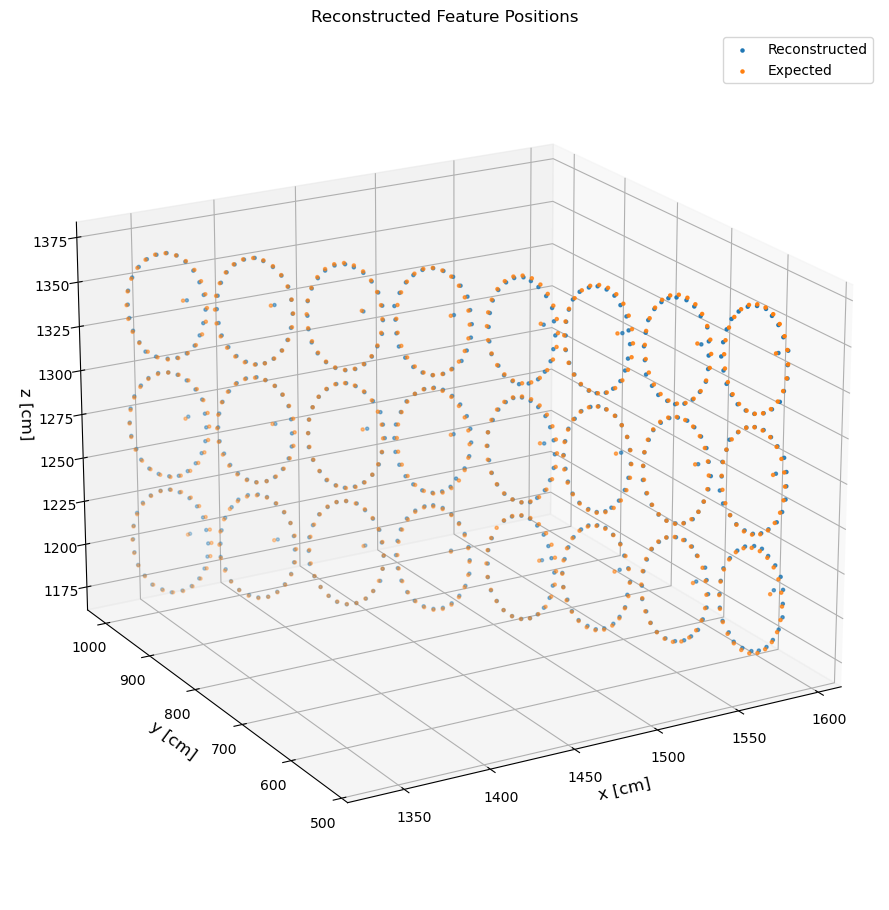

In [78]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reco_transformed[:,0], reco_transformed[:,1], reco_transformed[:,2], marker='.', label="Reconstructed", zorder=3)
ax.scatter(true_array[:,0], true_array[:,1], true_array[:,2], marker='.', label="Expected", zorder=2)
# for f in pmt_locations.keys():
#     i = fitter_all.feature_index[f]
#     ax.text(reco_transformed[i,0], reco_transformed[i,1], reco_transformed[i,2], f[:5], size=6, zorder=4, color='k')
#ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera", zorder=1)
plt.legend(loc=0)
fig.tight_layout()
ax.set_xlabel("x [cm]", fontsize=12)
ax.set_ylabel("y [cm]", fontsize=12)
ax.set_zlabel("z [cm]", fontsize=12)
ax.set_title("Reconstructed Feature Positions")
# rotate the plot to see the bolt ring
ax.view_init(20, -120)

## Plot reprojection errors

Text(0.75, 0.95, 'mean = 1.76 px\nmax = 13.10 px')

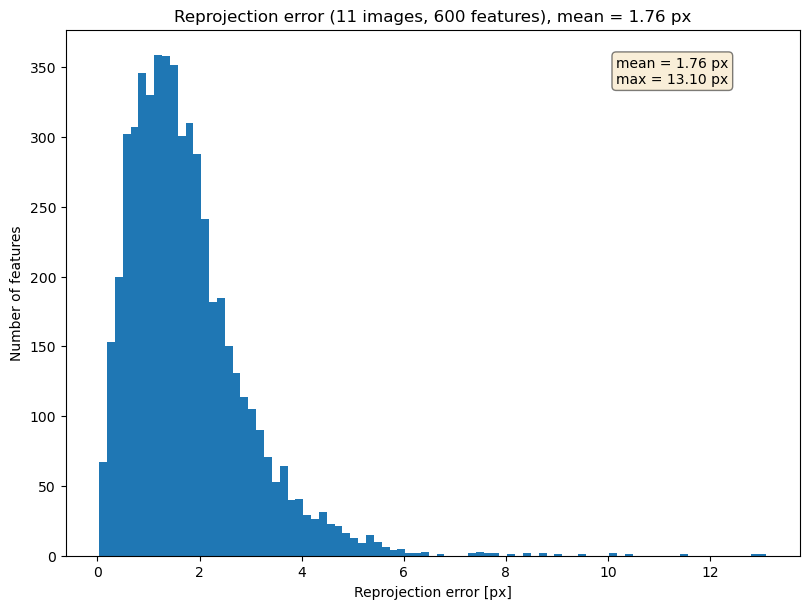

In [79]:
fig, ax = plt.subplots(figsize=(8,6))
reprojection_errors = fitter_all.reprojection_errors(fitter_all.camera_rotations, fitter_all.camera_translations, fitter_all.reco_locations)
reprojection_errors = linalg.norm(reprojection_errors.reshape((-1,2)), axis=1)
ax.hist(reprojection_errors, bins='auto')
ax.set_title("Reprojection error ({} images, {} features), mean = {:.2f} px".format(
    nimages, nfeatures, reprojection_errors.mean()))
fig.tight_layout()
ax.set_xlabel("Reprojection error [px]")
ax.set_ylabel("Number of features")

# put the mean and max reprojection errors on the plot without overlapping the histogram
ax.text(0.75, 0.95, "mean = {:.2f} px\nmax = {:.2f} px".format(reprojection_errors.mean(), reprojection_errors.max()), transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

In [ ]:
# Sort the images/features by highest reprojection errors, for manual checking
print(np.array(np.unravel_index(np.argsort(linalg.norm(fitter_all.reprojected_locations()-fitter_all.image_feature_locations, axis=2).ravel()), (nimages, nfeatures))))
print(linalg.norm(fitter_all.reprojected_locations()-fitter_all.image_feature_locations, axis=2)[1, 90])
print(fitter_all.index_feature[323])

## Plots of differences between expected and reconstructed geometry

Text(0.75, 0.95, 'mean = 1.12 cm\nmax = 4.02 cm')

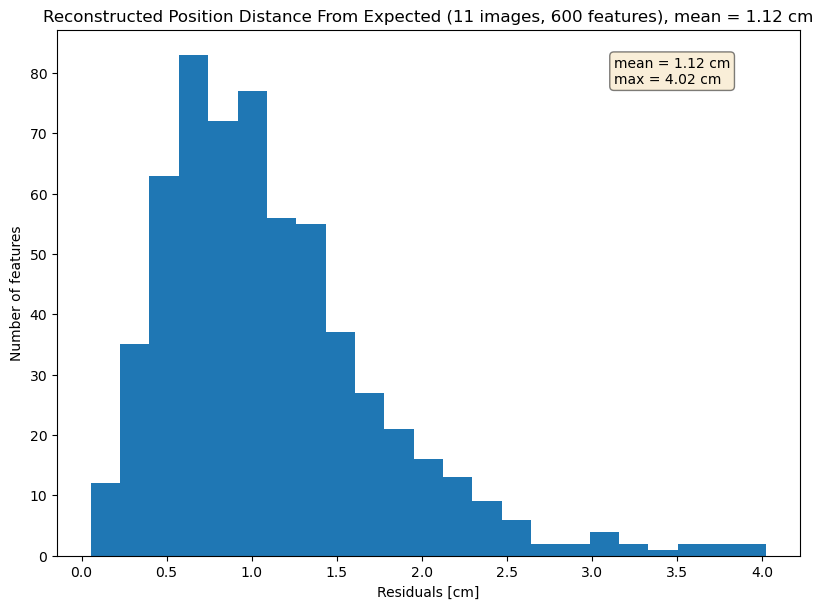

In [81]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(linalg.norm(errors, axis=1), bins='auto')
ax.set_title("Reconstructed Position Distance From Expected ({} images, {} features), mean = {:.2f} cm".format(
    nimages, nfeatures, linalg.norm(errors, axis=1).mean()))
fig.tight_layout()
ax.set_xlabel("Residuals [cm]")
ax.set_ylabel("Number of features")

# put the mean and max reprojection errors on the plot without overlapping the histogram
ax.text(0.75, 0.95, "mean = {:.2f} cm\nmax = {:.2f} cm".format(linalg.norm(errors, axis=1).mean(), linalg.norm(errors, axis=1).max()), transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))


In [82]:
# save residuals to a text file called newFD_residuals_final_.txt in the 'results/' folder. Add a column in the beginning with the feature name

SyntaxError: unexpected EOF while parsing (605112785.py, line 2)

In [61]:
print(len(reprojection_errors))

5378


In [22]:
## Save reconstructed positions, reprojection errors and residuaals to text files

# save the reconstructed positions to a text file called "reproduce_reconstructed_positions.txt" and put it in the 'results/24_PMT_Study/' folder. Add a column in the beginning with the feature name
np.savetxt('results/LI_reconstructed_final_2.txt', np.hstack((np.array([fitter_all.index_feature[i] for i in range(len(fitter_all.index_feature))]).reshape((len(fitter_all.index_feature), 1)), reco_transformed)), fmt='%s', delimiter='\t')

# save the reprojection_errors to a text file called "LI_res_final_2.txt" and put it in the 'results/' folder. Add a column in the beginning with the feature name
# np.savetxt('results/LI_res_final_2.txt', np.hstack((np.array([fitter_all.index_feature[i] for i in range(len(fitter_all.index_feature))]).reshape((len(fitter_all.index_feature), 1)), linalg.norm(fitter_all.reprojection_errors(fitter_all.camera_rotations, fitter_all.camera_translations, fitter_all.reco_locations).reshape((-1,2)), axis=1).reshape((len(fitter_all.index_feature), 1))), fmt='%s', delimiter='\t')


# save the residuals to a text file called "newFD_residuals_matlab_polygon.txt" and put it in the 'results/24_PMT_Study/' folder. Add a column in the beginning with the feature name
# np.savetxt('results/LI_residuals_final_2.txt', np.hstack((np.array([fitter_all.index_feature[i] for i in range(len(fitter_all.index_feature))]).reshape((len(fitter_all.index_feature), 1)), linalg.norm(errors))), fmt='%s', delimiter='\t')

In [21]:
bolt_dict = {b: reco_transformed[fitter_all.feature_index[b]] for b in common_bolt_locations.keys()}
bolt_dists = sk.get_bolt_distances(bolt_dict)


In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(bolt_dists, bins='auto')
ax.set_title("Reconstructed distance between adjacent bolts (cm)")
ax.axvline(linewidth=2, color='r', x=sk.bolt_distance)
fig.tight_layout()

# include the mean and std of bolt distances on the plot
ax.text(0.05, 0.95, "mean = {:.2f} cm\nstd = {:.2f} cm".format(np.mean(bolt_dists), np.std(bolt_dists)), transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.set_xlabel("Distance between adjacent bolts (cm)")
ax.set_ylabel("Number of bolts")

# print mean and std of bolt distances
print ('mean and std of bolt distances:', np.mean(bolt_dists), np.std(bolt_dists))

In [22]:
bolt_radii = sk.get_bolt_ring_radii(bolt_dict)


In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(bolt_radii, bins='auto')
ax.set_title("Reconstructed distance between bolts and centre of bolt ring (cm)")
ax.axvline(linewidth=2, color='r', x=sk.bolt_ring_radius)
fig.tight_layout()

# include the mean and std of bolt radii on the plot
ax.text(0.05, 0.95, "mean = {:.2f} cm\nstd = {:.2f} cm".format(np.mean(bolt_radii), np.std(bolt_radii)), transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.set_xlabel("Distance between bolts and centre of bolt ring (cm)")
ax.set_ylabel("Number of bolts")

# print mean and std of bolt distances
print ('mean and std of bolt radii:', np.mean(bolt_radii), np.std(bolt_radii))


In [40]:
## Save the bolt distances and bolt radii to text files

# save the bolt distances to a text file called "reproduce_bolt_distances.txt" and put it in the 'results/24_PMT_Study/' folder
np.savetxt('results/LI_bolt_dists.txt', bolt_dists, fmt='%s', delimiter='\t')

# save the bolt radii to a text file called "reproduce_bolt_radii.txt" and put it in the 'results/24_PMT_Study/' folder
np.savetxt('results/LI_bolt_radii.txt', bolt_radii, fmt='%s', delimiter='\t')

In [23]:
planes = sk.get_bolt_ring_planes(bolt_dict)
# flip planes if they're facing wrong direction (all normals should point towards tank centre)
plt.figure(figsize=(8,6))
ax = plt.subplot(111, projection='3d')
NN = 100
for pmt in sk.get_unique_pmt_ids(bolt_dict):
    pmt_bolt_coords = np.array([l for b, l in bolt_dict.items() if b[:5] == pmt])
    icolor = 'b' if int(pmt)>607 else 'orange' 
    ax.scatter(pmt_bolt_coords[:,0], pmt_bolt_coords[:,1], pmt_bolt_coords[:,2], color=icolor)
    p, n = planes[pmt]
    X,Y,Z = [[p[i]-n[i]*NN, p[i]+n[i]*NN] for i in range(3)]
    ax.plot(X,Y,Z,color=icolor)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(1200,1800)
ax.set_ylim(500, 1100)
ax.set_zlim(1000, 1500)
ax.view_init(90, -140)
ax.set_title('Supermodule Planes')

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [34]:
####### calculate the mean normal angles
###### mean normal direction of left 12 and right 12
normals1 = np.array([n for pmt, (p, n) in planes.items() if int(pmt) <= 607])
normals2 = np.array([n for pmt, (p, n) in planes.items() if int(pmt) > 607])
N1 = np.mean(normals1, axis=0)
N2 = np.mean(normals2, axis=0)
print ('norm (avg of 12 angles)', N1, N2)

##### normal for fitting all 12 at once
N1_all = sk.get_supermodule_plane(bolt_dict, 451, 606)[1]
N2_all = sk.get_supermodule_plane(bolt_dict, 655, 810)[1]
print ('norm (simultanous fit 12 PMTs)', N1_all, N2_all)

###### difference
print ('diff (degrees)', np.degrees(np.arccos(np.dot(N1, N1_all))), np.degrees(np.arccos(np.dot(N1, N2_all))))

In [35]:
cos1=np.dot(normals1, N1_all)
cos2=np.dot(normals2, N2_all)
theta1=np.degrees(np.arccos(cos1))
theta2=np.degrees(np.arccos(cos2))
diff_2walls = np.degrees(np.arccos(np.dot(N1_all, N2_all)))

# print (cos1)
# print (cos2)
print ('Angle between 2 walls (using normals fitted to 12 PMTs simultaneously):',diff_2walls)
print (theta1)
print (theta2)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.hist(theta1, histtype='step', bins=10, range=(0,2.3),label='left 12 PMTs')
ax.hist(theta2, histtype='stepfilled', bins=10, range=(0,2.3),label='right 12 PMTs',alpha=0.5)
ax.set_xlabel('Angle from normal (degree)', fontsize=14)
ax.set_title('Angle between 2 groups (degrees):%.2f'%(diff_2walls), fontsize=14)
ax.legend( fontsize=14)
ax.set_ylabel('Number of PMTs', fontsize=14)
ax.set_ylim(0,4)
plt.tight_layout()

In [ ]:
# import text file LI_reconstructed_final_2.txt into pandas dataframe
import pandas as pd

df = pd.read_csv('results/LI_reconstructed_final_2.txt', sep='\t', header=None)
df.columns = ['feature', 'x', 'y', 'z']


In [ ]:
# make pmts_df with only entries which have '00' in the feature name
pmts_df = df[df['feature'].str.contains('00')]

# make column1_df for all entries which have x and y which are within 4cm of pmt_locations['00622-00'][0], pmt_locations['00622-00'][1] respectivelly
column1_df = pmts_df[(pmts_df['x'] > pmt_locations['00622-00'][0]-4) & (pmts_df['x'] < pmt_locations['00622-00'][0]+4) & (pmts_df['y'] > pmt_locations['00622-00'][1]-4) & (pmts_df['y'] < pmt_locations['00622-00'][1]+4)]

# rearrange column1_df to have the entries so the feature label is in ascending order
column1_df = column1_df.sort_values(by='feature')

In [41]:
print(column1_df)

        feature            x           y            z
7351   00613-00  1479.051061  814.753248 -1761.171651
2908   00614-00  1478.541262  815.328332 -1694.023964
4426   00615-00  1477.152666  815.082772 -1627.726948
2011   00616-00  1477.007654  815.642346 -1550.849487
12482  00617-00  1477.608932  815.824599 -1483.956174
1225   00618-00  1476.269987  815.742181 -1416.647760
11531  00619-00  1474.506792  814.722342 -1338.042338
11640  00620-00  1477.008968  815.615820 -1271.589136
8193   00621-00  1477.844300  816.283951 -1204.489907
14531  00622-00  1477.035440  815.753579 -1128.069828
6269   00623-00  1477.880616  816.162292 -1060.454180
6994   00624-00  1479.981189  817.202325  -992.744394
7856   00625-00  1480.891722  817.261502  -914.595368
6574   00626-00  1479.177388  816.807066  -848.078471
488    00627-00  1477.770237  816.022136  -779.464848
13071  00628-00  1477.049690  815.158775  -702.721389
14533  00629-00  1477.675101  815.753237  -636.871608
439    00630-00  1478.772496

[ 1477.66    814.519 -1127.5  ]
1687.2819198228256


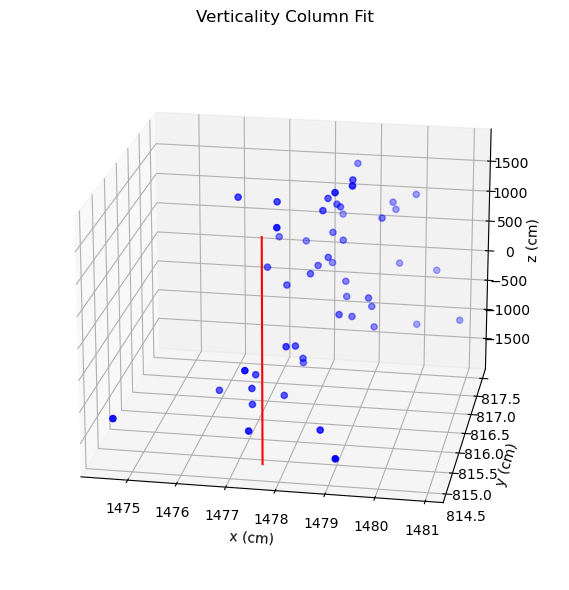

In [54]:
## fitting columns

# get the coordinates for PMT 00622-00 from the seed geometry locations held in true_array
print(pmt_locations['00622-00'])

# calculate radial distance from (0, 0, -1127.5) to the PMT 00622-00
r = linalg.norm(pmt_locations['00622-00'][:2])
print(r)

# at r, make a 3d plot of vertical column from z = [-1500, 1500]
z = np.linspace(-1770, 1770, 100)
x = r*np.cos(np.arctan2(pmt_locations['00622-00'][1], pmt_locations['00622-00'][0]))*np.ones_like(z)
y = r*np.sin(np.arctan2(pmt_locations['00622-00'][1], pmt_locations['00622-00'][0]))*np.ones_like(z)


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label='Fitted Column', color='r')
# plot column1_df
ax.scatter(column1_df['x'], column1_df['y'], column1_df['z'], label='Reconstructed PMTs', color='b')
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.set_zlabel('z (cm)')
ax.set_title('Verticality Column Fit')
# rotate the plot by 90 degrees
ax.view_init(20, -80)
plt.tight_layout()
